In [1]:
from PIL import Image
import requests
import torch

imports modules for registration

In [2]:
from common.registry import registry
from processors import *
from models import *
from utils.blip_utils import build_default_model 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

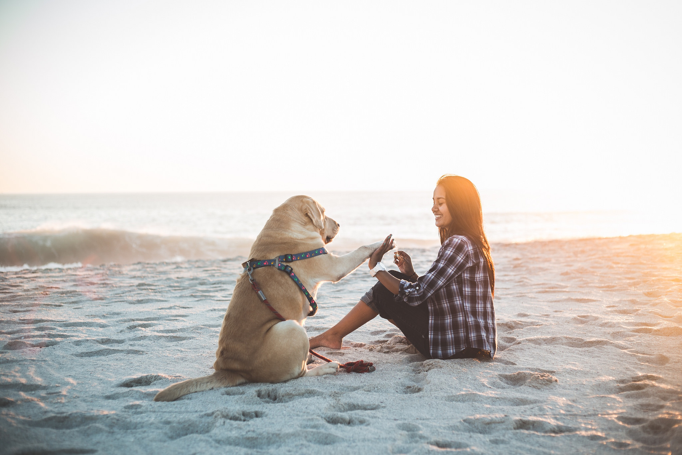

In [4]:
def load_demo_image():
    img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//3,h//3)))

    return raw_image
image = load_demo_image()

# 1. create image processors with arguments.
vis_processor = BlipCOCOImageEval(image_size=384)


# 2. Create default image processors from empty config.
# print(registry.get_processor_class("blip_coco_ret_vis_eval"))
# vis_processor = registry.get_processor_class("blip_coco_ret_vis_eval") \
#                         .build_from_cfg(OmegaConf.create())

# 3. Create image processors with customized configuration.
# config = OmegaConf.create({"image_size": 384})
# vis_processor = registry.get_processor_class("blip_coco_ret_vis_eval") \
#                         .build_from_cfg(cfg=config)


vis_input = vis_processor(image).unsqueeze(0).to(device)

samples = {'image': vis_input}

models

In [5]:
# (1) build model with default architecture (base)
# model = registry.get_model_class("blip_enc_dec") \
#                 .build_default_model()
# model = build_default_model('blip_caption', 'base')

# (2) build model with specific architecture (base)
# model = registry.get_model_class("blip_caption") \
#                 .build_default_model(model_type="large")

# model = build_default_model(name="blip_caption", model_type="large")
# (2a) To add a new model type
#    - write a model configuration file
#         e.g. configs/models/blip_caption_base.yaml
#    - add the configuration filepath to model default
#         e.g. models/blip_model.py, line 33

# # (3) build model with customized encoder decoder
# # (3a) build modules from OmegaConfig instance.
from models.med import XBertLMHeadDecoder
from omegaconf import OmegaConf
config = OmegaConf.create({"med_config_path": "configs/models/med_config.json"})
decoder = XBertLMHeadDecoder.build_from_cfg(cfg=config)
# # (3b) build modules by __init__()
from models.vit import VisionTransformerEncoder
encoder = VisionTransformerEncoder(img_size=384)

# # (3c) Expecting good captions
prompt = "a picture of "
# Expecting less satisfactory captions.
# prompt = ""

model = BlipCaption(image_encoder=encoder, text_decoder=decoder, prompt=prompt)

# print("loading pretrain weights.")
# url_or_filename = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_caption_capfilt_large.pth"
# # url_or_filename = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth"
url_or_filename = "./output/Caption_coco/checkpoint_best.pth"

model, msg = BlipCaption.load_from_pretrained(model, url_or_filename)


load checkpoint from ./output/Caption_coco/checkpoint_best.pth


In [6]:
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    caption = model.generate(samples=samples, use_nucleus_sampling=False, num_beams=3, max_length=20, min_length=5) 
    print('beam: '+caption[0])
    # nucleus sampling
    caption = model.generate(samples=samples, use_nucleus_sampling=True, top_p=0.9, max_length=20, min_length=5) 
    print('nucl: '+caption[0])

beam: a woman sitting in the sand with a dog
nucl: a woman sitting on the beach with her dog


In [7]:
# qa_model = registry.get_model_class("blip_vqa").build_default_model(model_type="base")
qa_model = build_default_model(name="blip_vqa", model_type="base") 

qa_model.eval()
qa_model = qa_model.to(device)

vis_processor = BlipCOCOImageEval(image_size=480)
text_processor = BlipCOCOText()

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth


In [8]:
vis_input = vis_processor(image)

question = "what is the girl wearing?"
# question = "why girl is happy?"
question = text_processor(question)

vqa_samples = {'image': vis_input.unsqueeze(0).to(device), 
               'question': [question]}

anwsers = qa_model.predict_answers(vqa_samples, inference_method="generate")
print(anwsers)

['plaid shirt']
